# GMM in PCA space of ensemble of reanalysis datasets

In [1]:
from importlib import reload
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cartopy as ctp
import seaborn as sns
from sklearn import mixture, decomposition

from latgmm.utils import utenso, preproc, eof, utdata, utstats, metric
import latgmm.geoplot as gpl

plt.style.use("../paper.mplstyle")

## Load data

In [2]:
datafile = "../data/reanalysis/monthly/ssta_merged_dataset_1.nc"
normalization = 'zscore'

ds = xr.open_dataset(datafile)

# Normalization
if normalization is not None:
    attributes = {}
    ds_norm = []
    for var in list(ds.data_vars):
        scaler = preproc.Normalizer(method=normalization)
        buff = scaler.fit_transform(ds[var])
        buff.attrs = {'normalizer': scaler}
        ds_norm.append(buff)

    ds = xr.merge(ds_norm) 

### EOF transformation

In [3]:
n_components = 3
sppca = eof.SpatioTemporalPCA(ds, n_components=n_components)
eofs = sppca.get_eofs()
pcs = sppca.get_principal_components()
pcs = pcs.assign_coords(member=('time', ds['member'].data))
print(f"Explained variance: {np.sum(sppca.explained_variance())}")

Explained variance: 0.5470192087586864


Plot EOF maps.

array([<GeoAxes: >, <GeoAxes: >, <GeoAxes: >], dtype=object)

/home/jakob/Software/mambaforge/envs/latgmmenv/lib/python3.11/site-packages/IPython/core/events.py:93: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  func(*args, **kwargs)
/home/jakob/Software/mambaforge/envs/latgmmenv/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


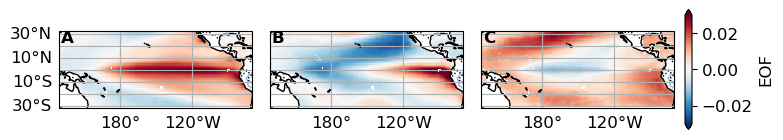

In [4]:
# EOF maps
vars = list(ds.data_vars)
fig = plt.figure(figsize=(7, 2*len(vars)))
proj = ctp.crs.PlateCarree(central_longitude=180)
axs = []
for i in range(sppca.n_components):
    comp = eofs.isel(eof=i)
    for j, var in enumerate(vars):
        ax = fig.add_subplot(len(vars), sppca.n_components, i+sppca.n_components*j+1, projection=proj)
        im = gpl.plot_map(comp[var], central_longitude=180, ax=ax,
                     bar='continuous', vmin=-.03, vmax=.03, add_bar=False)
        im['gl'].top_labels = False 
        if i > 0:
            im['gl'].left_labels = False 
        axs.append(ax)
        
cbar_ax = fig.add_axes([0.99, .2, 0.01, 0.6])
cb = fig.colorbar(im['im'], cax=cbar_ax, orientation='vertical', shrink=0.6, extend='both')
cb.set_label(label=rf"EOF")

gpl.enumerate_subplots(axs, pos_x=.01, pos_y=.85)

### Get ENSO events

In [5]:
reload(utenso)
month_range=[12, 2]
x_enso, x_events = utenso.select_enso_events(ds, month_range=month_range, threshold=0.5)
z_enso = xr.DataArray(
    data=sppca.transform(x_enso),
    coords={'time': x_enso['time'].data, 'eof': np.arange(1, sppca.n_components+1)}
).assign_coords(member=('time', x_enso['member'].data))
z_events = xr.DataArray(
    data=sppca.transform(x_events),
    coords={'time': x_events['time'].data, 'eof': np.arange(1, sppca.n_components+1)}
).assign_coords(member=('time', x_events['member'].data))

## Plot latent encoding

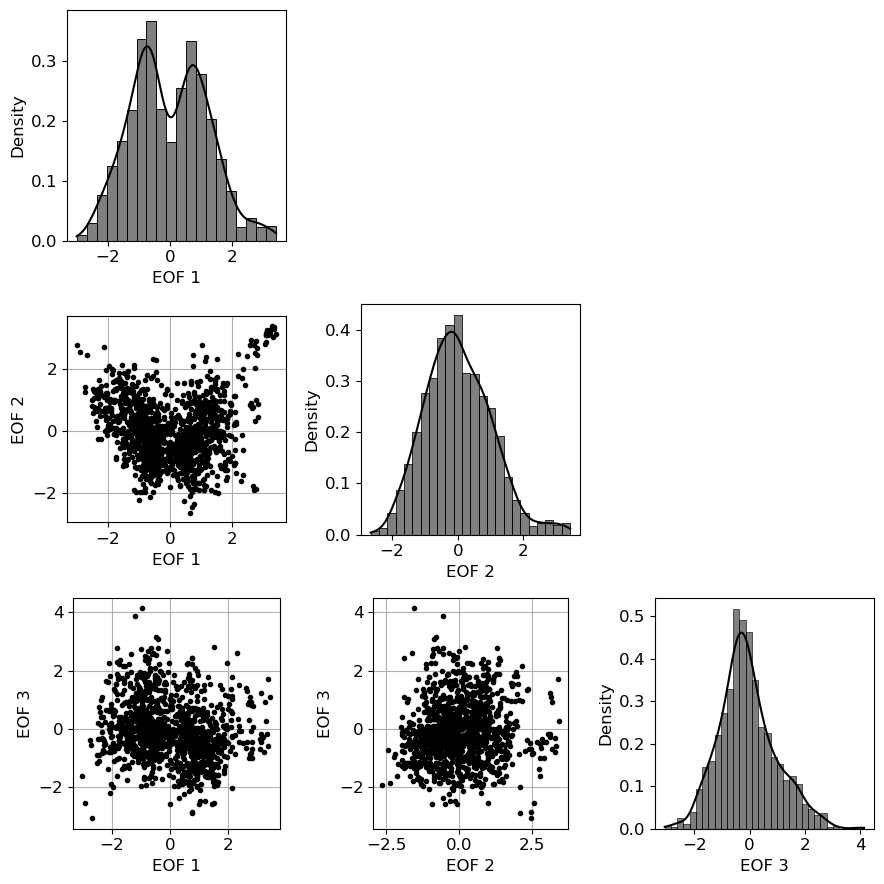

In [6]:
n_rows = z_enso['eof'].size
n_cols = n_rows

fig = plt.figure(figsize=(n_cols*3, n_rows*3))

for i in range(n_rows):
    for j in range(i+1):
        if i == j:
            ax = fig.add_subplot(n_rows, n_cols, i*n_rows+j+1)
            sns.histplot(z_enso.isel(eof=i).data, ax=ax, stat='density', kde=True, color='k')
            ax.set_xlabel(f"EOF {i+1}")
        else:
            ax = fig.add_subplot(n_rows, n_cols, i*n_rows+j+1)
            ax.plot(z_enso.isel(eof=j), z_enso.isel(eof=i), '.', color='k')
            ax.set_xlabel(f"EOF {j+1}")
            ax.set_ylabel(f"EOF {i+1}")
            ax.set_aspect('equal')
            ax.grid(True)

## Gaussian mixture 

### Scan number of cluster

In [ ]:
n_classes = np.arange(1, 10, 1)
n_runs = 100
result = []
for k in n_classes:
    for r in range(n_runs):
        gmm = mixture.GaussianMixture(n_components=k, 
                                      covariance_type='full', max_iter=100)
        gmm.fit(z_enso.data)
        result.append(
            {'k': k, 'bic': gmm.bic(z_enso.data), 'gmm': gmm}
        )
result = pd.DataFrame(result)

fig, ax = plt.subplots(figsize=(7,4))
ax = sns.boxplot(data=result, x='k', y='bic', ax=ax, color='cyan')

### Plot GMM

959


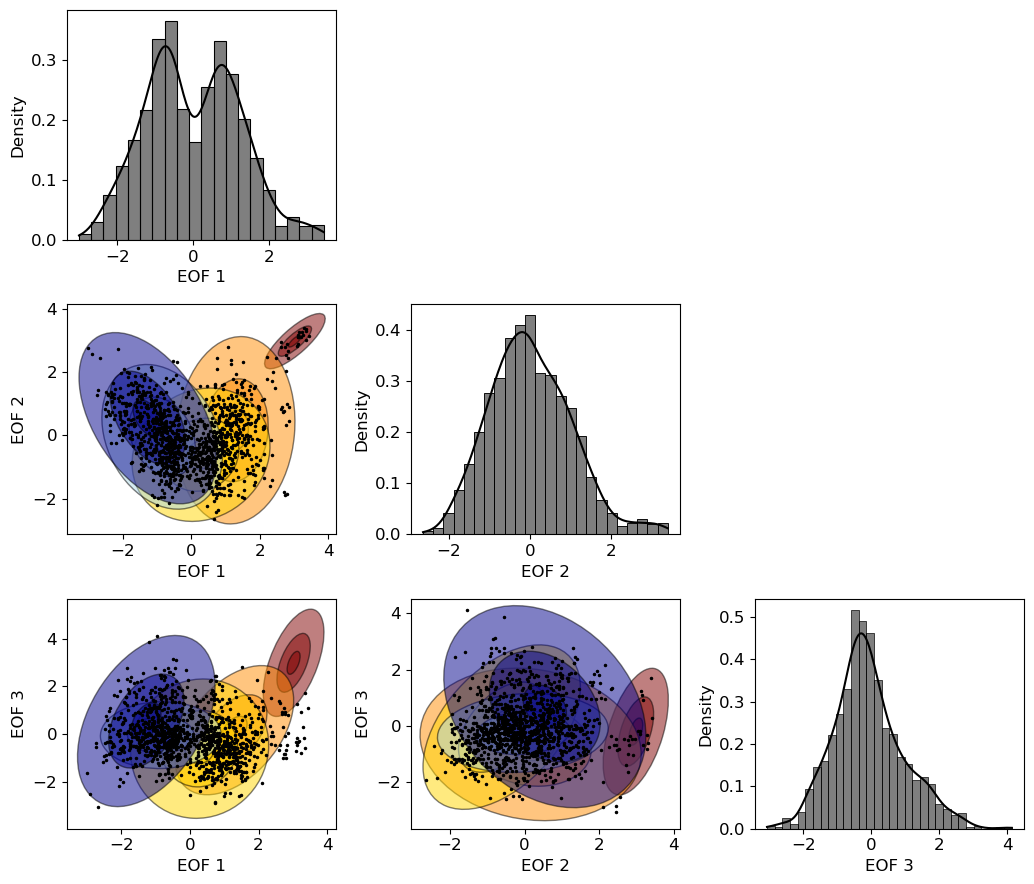

In [69]:
# Train GMM
n_cluster=5
if n_components == 3:
    n_rand = 959
elif n_components == 4:
    n_rand = 774 
else:
    n_rand = np.random.randint(0, 1000)
gmm_pca = mixture.GaussianMixture(n_components=n_cluster, 
                      covariance_type='full', max_iter=100,
                      random_state=n_rand, n_init=10, init_params='random_from_data')
gmm_pca.fit(z_enso.data)

#gmm_pca = result.iloc[result['bic'].argmin()]['gmm']

# Plots
n_rows = z_enso['eof'].size
n_cols = n_rows

fig = plt.figure(figsize=(n_cols*3.5, n_rows*3))

gmm_order = np.argsort(gmm_pca.means_[:,0])[::-1]
gmclrs = ['maroon', 'darkorange', 'gold', 'lightblue', 'darkblue', 'black']

for i in range(n_rows):
    for j in range(i+1):
        if i == j:
            ax = fig.add_subplot(n_rows, n_cols, i*n_rows+j+1)
            sns.histplot(z_enso.isel(eof=i).data, ax=ax, stat='density', kde=True, color='k')
            ax.set_xlabel(f"EOF {i+1}")
        else:
            ax = fig.add_subplot(n_rows, n_cols, i*n_rows+j+1)
            # Plot points
            ax.plot(z_enso.isel(eof=j), z_enso.isel(eof=i), '.', color='k', markersize=3)

            # Plot Gaussians
            for k, category in enumerate(gmm_order):
                mean = gmm_pca.means_[category, j:i+1]
                if gmm_pca.covariance_type == "full":
                    Sigma = gmm_pca.covariances_[category, :]
                elif gmm_pca.covariance_type == "diag":
                    Sigma = np.diag(gmm_pca.covariances_[category, :])
                
                sub_matrix = np.array([
                    [Sigma[j,j], Sigma[j,i]],
                    [Sigma[i,j], Sigma[i,i]]
                ])
                
                gmkwargs= dict(fill=False)
                if gmclrs is not None:
                    gmkwargs['ec'] = 'k' #gmclrs[i] 
                    gmkwargs['fc'] = gmclrs[k] 
                    gmkwargs['fill'] = True
                    gmkwargs['alpha'] = 0.5
            
                for p in [0.9, 0.5, 0.1]:
                    if p==0.1:
                        gmkwargs['label'] = f"c={category+1}"
                    gpl.plot_2dgaussian(mean, sub_matrix,
                                         ax=ax, p=p, **gmkwargs)
                        

            # Axes properties
            ax.set_xlabel(f"EOF {j+1}")
            ax.set_ylabel(f"EOF {i+1}")

print(n_rand)

### GMM means transformed to grid space

/tmp/ipykernel_80086/2391416759.py:38: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.savefig(f"../output/plots/pcgmm_gmmmeans_n{n_components}_k{n_cluster}.png", dpi=300, bbox_inches='tight')
/tmp/ipykernel_80086/2391416759.py:38: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.savefig(f"../output/plots/pcgmm_gmmmeans_n{n_components}_k{n_cluster}.png", dpi=300, bbox_inches='tight')
/home/jakob/Software/mambaforge/envs/latgmmenv/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


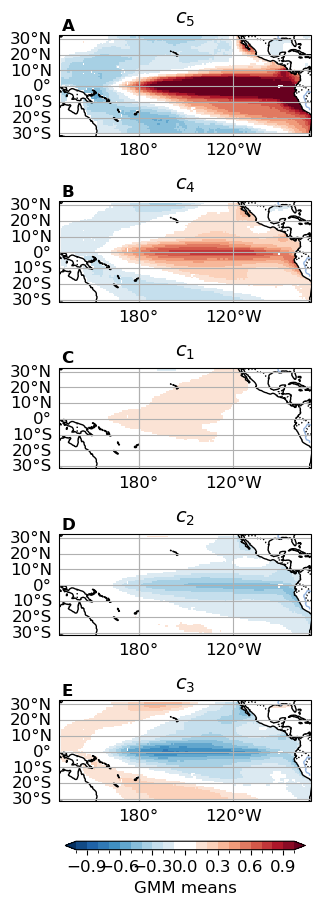

In [70]:
# Plot mean of Gaussian mixtures
plparam = {'ssta': dict(vmin=-1, vmax=1, step=0.1, cmap='RdBu_r', centercolor="#ffffff"),
           'ssha': dict(vmin=-.15, vmax=.15, step=0.025,cmap='RdGy_r', centercolor="#ffffff")}
labels = ['Extreme El Nino', 'EP El Nino', 'CP El Nino', 'EP La Nina', 'CP La Nina',]

means = sppca.inverse_transform(gmm_pca.means_, newdim='mu')
means = ds['ssta'].attrs['normalizer'].inverse_transform(means)
# Unnormalize
if 'normalizer' in ds[list(ds.data_vars)[0]].attrs.keys():
    for var in list(ds.data_vars):
        means[var] = ds[var].attrs['normalizer'].inverse_transform(means[var])

vars = ds.data_vars
fig = plt.figure(figsize=(4, 1.7*len(gmm_order)))
proj = ctp.crs.PlateCarree(central_longitude=180)
axs = []
for i, k in enumerate(gmm_order):
    mu = means.sel(mu=k)
    for j, var in enumerate(vars):
        idx = len(vars)*i+j+1
        ax = fig.add_subplot(len(gmm_order), 1, idx, projection=proj)
        im = gpl.plot_map(mu[var], central_longitude=180, ax=ax, 
                          bar='discrete', add_bar=False, **plparam[var])
        im['gl'].top_labels = False 
        ax.set_title(rf"$c_{k+1}$", fontsize=14)
        axs.append(ax)

# Shared colorbar
cbar_ax = fig.add_axes([0.2, -.01, 0.6, 0.01])
cbar = plt.colorbar(im['im'], orientation='horizontal', shrink=0.7,
                    cax=cbar_ax, extend='both')
cbar.set_label(f"GMM means", size=12)

_ = gpl.enumerate_subplots(axs, pos_x=0.01, pos_y=1.05, fontsize=12)

if True:
    means.to_netcdf(f"../output/pcgmm/pcgmm_n{n_components}_k{n_cluster}_gmmmeans.nc")
    plt.savefig(f"../output/plots/pcgmm_gmmmeans_n{n_components}_k{n_cluster}.png", dpi=300, bbox_inches='tight')


## Probabilistic weights

In [ ]:
# Event weights
p_c_given_x = utenso.posterior_weights(
    z_events.data, means=gmm_pca.means_, covariances=gmm_pca.covariances_,
    prior_weights=gmm_pca.weights_
)
# convert to xarray
p_c_given_x_da = xr.DataArray(data=p_c_given_x, dims=['time', 'classes'], 
                              coords={ 
                                'time': z_events['time'].data,
                                'member': ('time', z_events['member'].data),
                                'classes': np.arange(p_c_given_x.shape[1]) + 1
                              })

# Mean posterior weights
timepoints = np.unique(p_c_given_x_da['time'].data)
p_c_given_x_mean = []
p_c_given_x_std = []
for t in timepoints:
    weight = p_c_given_x_da.sel(time=t)
    if len(weight.shape) > 1:
        p_c_given_x_mean.append(weight.mean(dim='time').data)
        p_c_given_x_std.append(weight.std(dim='time').data)
    else:
        p_c_given_x_mean.append(weight.data)
        p_c_given_x_std.append(np.zeros(shape=weight.shape))

p_c_given_x_mean = xr.DataArray(data=p_c_given_x_mean, coords={'time':timepoints, 'classes':p_c_given_x_da['classes']})        
p_c_given_x_std = xr.DataArray(data=p_c_given_x_std, coords={'time':timepoints, 'classes':p_c_given_x_da['classes']})        

In [ ]:
#  Plot posterior weights
labels = ['Extreme El Nino', 'EP El Nino', 'CP El Nino', 'EP La Nina', 'CP La Nina', "rest"]
n_samples, n_classes = p_c_given_x.shape
fig, axs = plt.subplots(n_classes, 1, figsize=(7, 1.5*n_classes), sharex='col', sharey='row')

for i, k in enumerate(gmm_order):
    axs[i].bar(p_c_given_x_mean['time'].data, height=p_c_given_x_mean.sel(classes=k+1),
                 width=4e2, color=gmclrs[i], label=labels[i])
    axs[i].grid(axis='x')
    axs[i].set_ylabel(rf'$p(c_{k+1}|z)$')
    axs[i].set_ylim([0,1])
    axs[i].set_yticks([0, .5, 1])
    axs[i].legend(bbox_to_anchor=(.72, 1.0, 0.3, 0.1), loc="lower right", fontsize=10)

gpl.enumerate_subplots(axs, pos_x=0.01, pos_y=1.1, fontsize=12)


In [ ]:
# Std of weights between datasets
labels = ['Extreme El Nino', 'EP El Nino', 'CP El Nino', 'EP La Nina', 'CP La Nina',]
fig, axs = plt.subplots(n_classes, 1, figsize=(7, 1.1*n_classes), sharex='col', sharey='row')

for i, k in enumerate(gmm_order):
    axs[i].bar(p_c_given_x_std['time'].data, height=p_c_given_x_std.sel(classes=k+1),
                 width=4e2, color=gmclrs[i], label=rf"{labels[i]}")
    axs[i].grid(axis='x')
    axs[i].set_ylabel(rf'$\sigma ( p(c_{k+1}|z))$')
    axs[i].set_ylim([0,1])
    axs[i].set_yticks([0, .5, 1])
    axs[i].legend(bbox_to_anchor=(.7, .5, 0.3, 0.1), loc="lower right", fontsize=10)

_ = gpl.enumerate_subplots(axs, pos_x=0.01, pos_y=.75, fontsize=12)

Compute monthly weights

In [ ]:
# Monthly weights
p_c_given_x_month = utenso.posterior_weights(
    z_enso.data, means=gmm_pca.means_, covariances=gmm_pca.covariances_,
    prior_weights=gmm_pca.weights_
)
# convert to xarray
p_c_given_x_month = xr.DataArray(data=p_c_given_x_month, dims=['time', 'classes'], 
                              coords={ 
                                'time': z_enso['time'].data,
                                'member': ('time', z_enso['member'].data),
                                'classes': np.arange(p_c_given_x_month.shape[1]) + 1
                              })

# Mean posterior weights
timepoints = np.unique(p_c_given_x_month['time'].data)
weight_month_mean = []
weight_month_std = []
for t in timepoints:
    weight = p_c_given_x_month.sel(time=t)
    if len(weight.shape) > 1:
        weight_month_mean.append(weight.mean(dim='time').data)
        weight_month_std.append(weight.std(dim='time').data)
    else:
        weight_month_mean.append(weight.data)
        weight_month_std.append(np.zeros(shape=weight.shape))

weight_month_mean = xr.DataArray(data=weight_month_mean, coords={'time':timepoints, 'classes':p_c_given_x_month['classes']})        
weight_month_std = xr.DataArray(data=weight_month_std, coords={'time':timepoints, 'classes':p_c_given_x_month['classes']})        

## Weighted composites over all products

In [ ]:
for i, member in enumerate(np.unique(p_c_given_x_month['member'])):
    idx_member = np.where(p_c_given_x_month['member'].data == member)[0]
    weights = p_c_given_x_month.isel(time=idx_member)
    da_member = ds['ssta'].isel(time=np.where(ds['ssta']['member'].data == member)[0])
    da_member = da_member.sel(time=weights['time'].data)

    # Weighted mean
    weighted_mean_member = []
    for j, k in enumerate(weights['classes'].data):
        weight_class = weights.sel(classes=k)
        da_member_weighted = da_member.weighted(weight_class)
        weighted_mean_member.append(da_member_weighted.mean(dim='time'))
    weighted_mean_member = xr.concat(weighted_mean_member,
                                     dim=pd.Index(weights['classes'].data, name='classes'))
    weighted_mean = weighted_mean_member if i == 0 else (weighted_mean + weighted_mean_member)/2

In [ ]:
# Plot mean of Gaussian mixtures
plparam = dict(vmin=-2.5, vmax=2.5, step=0.5, cmap='RdBu_r', centercolor="#ffffff")
labels = ['Extreme El Nino', 'EP El Nino', 'CP El Nino', 'EP La Nina', 'CP La Nina']

fig = plt.figure(figsize=(4*len(vars), 1.7*len(gmm_order)))
proj = ctp.crs.PlateCarree(central_longitude=180)
for i, k in enumerate(gmm_order):
    mu = weighted_mean.sel(classes=k+1)

    ax = fig.add_subplot(len(gmm_order), len(vars), i+1, projection=proj)
    im = gpl.plot_map(mu, central_longitude=180, ax=ax, 
                      bar='discrete', add_bar=False, **plparam)
    im['gl'].top_labels = False 
    ax.set_title(rf"$c_{k}$", fontsize=12)

# Shared colorbar
cbar_ax = fig.add_axes([0.2, -.01, 0.6, 0.01])
cbar = plt.colorbar(im['im'], orientation='horizontal', shrink=0.7,
                    cax=cbar_ax, extend='both')
cbar.set_label(f"SST anomalies", size=12)


### Weighted composites over decoded PC-data

In [ ]:
# Inverse transform data
da_decoded = sppca.inverse_transform(z_enso.data, newdim=pd.Index(z_enso['time'].data, name='time'))['ssta']
da_decoded = da_decoded.assign_coords(member=('time', z_enso['member'].data))

In [ ]:
# Compute weighted mean for each class
for i, member in enumerate(np.unique(p_c_given_x_month['member'])):
    idx_member = np.where(p_c_given_x_month['member'].data == member)[0]
    weights = p_c_given_x_month.isel(time=idx_member)
    da_member = da_decoded.isel(time=np.where(da_decoded['member'].data == member)[0])
    da_member = da_member.sel(time=weights['time'].data)

    # Weighted mean
    weighted_mean_member = []
    for j, k in enumerate(weights['classes'].data):
        weight_class = weights.sel(classes=k)
        da_member_weighted = da_member.weighted(weight_class)
        weighted_mean_member.append(da_member_weighted.mean(dim='time'))
    weighted_mean_member = xr.concat(weighted_mean_member,
                                     dim=pd.Index(weights['classes'].data, name='classes'))
    weighted_mean_decoded = weighted_mean_member if i == 0 else (weighted_mean_decoded + weighted_mean_member)/2

In [ ]:
# Plot mean of Gaussian mixtures
plparam = dict(vmin=-2.5, vmax=2.5, step=0.5, cmap='RdBu_r', centercolor="#ffffff")
labels = ['Extreme El Nino', 'EP El Nino', 'CP El Nino', 'EP La Nina', 'CP La Nina']

fig = plt.figure(figsize=(4*len(vars), 1.7*len(gmm_order)))
proj = ctp.crs.PlateCarree(central_longitude=180)
for i, k in enumerate(gmm_order):
    mu = weighted_mean_decoded.sel(classes=k+1)

    ax = fig.add_subplot(len(gmm_order), len(vars), i+1, projection=proj)
    im = gpl.plot_map(mu, central_longitude=180, ax=ax, 
                      bar='discrete', add_bar=False, **plparam)
    im['gl'].top_labels = False 
    ax.set_title(labels[i], fontsize=12)

# Shared colorbar
cbar_ax = fig.add_axes([0.2, -.01, 0.6, 0.01])
cbar = plt.colorbar(im['im'], orientation='horizontal', shrink=0.7,
                    cax=cbar_ax, extend='both')
cbar.set_label(f"SSTA", size=12)

#plt.savefig(f"../output/plots/pcgmm_means_k{n_cluster}.png", dpi=300, bbox_inches='tight')


In [ ]:
# Plot mean of Gaussian mixtures
plparam = {'ssta': dict(vmin=-1.5, vmax=1.5, step=0.25, cmap='RdBu_r', centercolor="#ffffff"),
           'ssha': dict(vmin=-.15, vmax=.15, step=0.025,cmap='RdGy_r', centercolor="#ffffff")}
labels = ['Extreme El Nino', 'EP El Nino', 'CP El Nino', 'EP La Nina', 'CP La Nina',]

means = sppca.inverse_transform(gmm_pca.means_, newdim='mu')
# Unnormalize
if 'normalizer' in ds[list(ds.data_vars)[0]].attrs.keys():
    for var in list(ds.data_vars):
        means[var] = ds[var].attrs['normalizer'].inverse_transform(means[var])

vars = ds.data_vars
fig = plt.figure(figsize=(4*len(gmm_order)//2, 3*len(gmm_order)//2))
proj = ctp.crs.PlateCarree(central_longitude=180)
axs = []
for i, k in enumerate(gmm_order):
    mu = means.sel(mu=k)
    for j, var in enumerate(vars):
        idx = len(vars)*i+j+1
        ax = fig.add_subplot(len(gmm_order)//2+1, len(gmm_order)//2, idx, projection=proj)
        im = gpl.plot_map(mu[var], central_longitude=180, ax=ax, 
                          bar='discrete', add_bar=False, **plparam[var])
        im['gl'].top_labels = False 
        ax.set_title(rf"$c_{k+1}$", fontsize=14)
#        ax.set_title(labels[i], fontsize=12)
        axs.append(ax)

# Shared colorbar
cbar_ax = fig.add_axes([0.2, -.01, 0.6, 0.01])
cbar = plt.colorbar(im['im'], orientation='horizontal', shrink=0.7,
                    cax=cbar_ax, extend='both')
cbar.set_label(f"GMM means", size=12)

_ = gpl.enumerate_subplots(axs, pos_x=0.01, pos_y=1.05, fontsize=12)

#plt.savefig(f"../output/plots/pcgmm_means_k{n_cluster}.png", dpi=300, bbox_inches='tight')

In [ ]:
# Save means
if False:
    means.attrs['gmm_sort'] = gmm_order
    means.to_netcdf("../output/pcgmm_sst_means_new.nc")

## Decadal variability of Nino3.4

In [ ]:
product = 'HadISST' #'COBE2','ErSSTv5','HadISST', 'ORAS5', 'GODAS', 'SODA', 'ERA5', 'CERA-20c' 
for fnames in data_config['filenames']:
    if fnames['name'] == product:
        filepath = fnames['path']
    
ssta = preproc.process_data(
        filepath, vars=['sst'], antimeridian=True,
        climatology='month', normalization=None, detrend_from=1950 
)['ssta']
nino_indices = utenso.get_nino_indices(ssta, antimeridian=True)
nino_indices = nino_indices.sel(time=slice(None, '2021-12-31'))

Monthly weighting of Nino3.4:

In [ ]:
weights = weight_month_mean
nino34 = nino_indices['nino34']
# Make sure weights and nino-indices are on the same time points
tmax = nino34['time'].max() if nino34['time'].max() < weights['time'].max() else weights['time'].max()
tmin = nino34['time'].min() if nino34['time'].min() > weights['time'].min() else weights['time'].min()
nino34 = nino34.sel(time=slice(tmin.data, tmax.data)).rolling(time=3, center=True).mean()
weights = weights.sel(time=slice(tmin.data, tmax.data))
weights['time'] = np.array(weights['time'].data, dtype='datetime64[M]')
nino34['time'] = np.array(nino34['time'].data, dtype='datetime64[M]')

nino34 = nino34.sel(time=weights['time'])

In [ ]:
fig, axs = plt.subplots(1, 2, 
                        width_ratios=[3,1],
                        figsize=(8, 2.5),
                        sharey=True)
#axs[0].bar(nino34['time'].data, height=nino34.data, width=4e2, label=rf'y', color='k')
im, bins, _ = axs[1].hist(nino34.data, bins='auto', density=True, orientation='horizontal',
                          histtype='bar', color='k', alpha=.5, label=rf'$y$')
for i, k in enumerate(gmm_order):
    n34_k = nino34 * weights.sel(classes=k+1)
    idx_nonzero = np.where(weights.sel(classes=k+1).data > 0.55)[0]
    n34_k = n34_k[idx_nonzero]
    axs[0].bar(n34_k['time'].data, height=n34_k.data, width=5e2,
                   color=gmclrs[i])#, label=rf'$p(c={k}|z_t) \cdot y$')
    axs[1].hist(n34_k.data, bins=bins, density=True, orientation='horizontal',
                histtype='step', color=gmclrs[i], linewidth=1.5, #alpha=.4,
                label=rf'$p(c={k}|z_t) \cdot y$')

axs[0].set_ylabel(f'$p_i \cdot y$')
axs[0].set_ylabel("Nino3.4")
axs[1].set_xlabel("density")
#axs[1].legend(bbox_to_anchor=(1., .1, .6, 1.), loc="lower left", ncol=1)
fig.legend(loc='upper center', ncol=3, bbox_to_anchor=(0.07, 1.15, .9, 0.1), mode='expand')
gpl.enumerate_subplots(axs, pos_x=0.03, pos_y=.85, fontsize=12)

### Decadal variability

In [ ]:
def rolling_window_covariance(da: xr.DataArray, window_size: int):
    covs = []
    times = []
    for i in range(window_size-1, len(da['time'])):
        # Select window
        chunk = da.isel(time=slice(i-window_size+1, i+1))
        # Compute covariance
        cov = np.cov(chunk.data)
        covs.append(cov)
        times.append(chunk.isel(time=int(window_size/2))['time'].data)
    
    return np.array(covs), np.array(times)


# Weights and Nino3.4 should span same time period
nino34 = nino34.sel(time=slice("1855-12-01", None))
weights = weights.sel(time=slice("1855-12-01", None)) 

# Weighted Nino3.4
nino34_k = []
for k in weights['classes']:
    nino34_k.append(nino34 * weights.sel(classes=k))
nino34_k = xr.concat(nino34_k, dim=pd.Index(weights['classes'].data, name='classes'))

# Rolling mean variance over n_years
n_years = 30
nino34_var, times = rolling_window_covariance(nino34, window_size=3*n_years)
nino34_var = xr.DataArray(nino34_var, coords=dict(time=times))
nino34_k_cov, times = rolling_window_covariance(nino34_k, window_size=3*n_years)
nino34_k_cov = xr.DataArray(nino34_k_cov, coords=dict(time=times, c1=nino34_k['classes'].data, c2=nino34_k['classes'].data))

# Sum of covariances
n_times, n_features, _ = nino34_k_cov.shape
sum_covariances = np.zeros(n_times)
for i in range(n_features):
    for j in range(i+1, n_features):
        sum_covariances += nino34_k_cov.data[:, i, j]
nino34_k_cov_sum = xr.DataArray(2*sum_covariances, coords=dict(time=nino34_k_cov['time'].data))

In [ ]:
# Stack plot every 10 years
n_step = 10
# Time points
year_arr = np.arange(np.array(nino34_k_cov['time'].min().data, dtype='datetime64[Y]'),
                     np.array(nino34_k_cov['time'].max().data, dtype='datetime64[Y]') + np.timedelta64(2, 'Y'),
                     step=n_step, dtype='datetime64[Y]')
time_arr = np.array([f"{y}-01-01" for y in year_arr], dtype='datetime64[D]')
# Select time points and stack plots
stacked_lines = [(nino34_k_cov.sel(time=time_arr, method='nearest').isel(c1=k, c2=k) / nino34_var
                  ) for k in gmm_order]
stacked_lines.append(
    nino34_k_cov_sum.sel(time=time_arr, method='nearest') / nino34_var
)

In [ ]:
import matplotlib.gridspec as gridspec
class_names = ['Extreme El Nino', 'EP El Nino', 'CP El Nino', 'EP La Nina', 'CP La Nina',]
clrs = gmclrs[:len(gmm_order)]
clrs.append('lightgrey')
labels = [rf"k={k}" for k in gmm_order]
labels.append("cov")
nrows, ncols = (3, 2)
fig = plt.figure(figsize=(9, nrows*2.))
gs = gridspec.GridSpec(nrows, ncols, width_ratios=[3,1], height_ratios=[2,1,2])
axs = [fig.add_subplot(gs[0,0]), fig.add_subplot(gs[0,1])]
axs.append(fig.add_subplot(gs[1,0], sharex=axs[0]))
axs.append(fig.add_subplot(gs[2,0], sharex=axs[0]))
axs.append(fig.add_subplot(gs[1:,1]))

# Nino34 time-series and hisplot
im, bins, _ = axs[1].hist(nino34.data, bins='auto', density=True, orientation='horizontal',
                          histtype='bar', color='k', alpha=.9, label=f'Nino3.4 ({product})')
for i, k in enumerate(gmm_order):
    n34_k = nino34 * weights.sel(classes=k+1)
    idx_nonzero = np.where(weights.sel(classes=k+1).data > 0.5)[0]
    n34_k = n34_k[idx_nonzero]
    axs[0].bar(n34_k['time'].data, height=n34_k.data, width=4e2,
                   color=gmclrs[i])
    axs[1].hist(n34_k.data, bins=bins, density=True, orientation='horizontal',
                histtype='step', color=gmclrs[i], linewidth=1.5, #alpha=.4,
                label=class_names[i])
#                label=r'$p(c_{k}|z_t) \cdot y$'.replace('k', str(k+1)))
axs[0].set_xlim(np.min(n34_k['time']).data, np.max(n34_k['time']).data)
axs[0].set_ylabel("Nino3.4")
axs[0].axvline(np.datetime64('1970-01-01'), ls=':', color='k')

axs[1].set_xlabel(r"density")

# Variance of Nino34
years = np.arange(np.array(nino34_var['time'].min().data, dtype='datetime64[Y]'),
                  np.array(nino34_var['time'].max().data, dtype='datetime64[Y]') + np.timedelta64(2, 'Y'),
                  step=10, dtype='datetime64[Y]')
variance = nino34_var.sel(time=years, method='nearest')
#axs[2].plot(nino34_var['time'], nino34_var, color='darkgreen',
#           label=r'$\sigma_{30y}$ (Nino3.4)')
#axs[2].fill_between(nino34_var['time'], np.zeros(len(nino34_var['time'])), nino34_var, color='darkgreen', alpha=.5)
axs[2].bar(years, height=variance, width=3e3, color='darkgreen', edgecolor='darkgreen', alpha=.5, 
           label=r'$\sigma$(Nino3.4)')
axs[2].set_ylabel(r"variance")
axs[2].axvline(np.datetime64('1970-01-01'), ls=':', color='k')

# Decadel variability
bottom = np.zeros_like(stacked_lines[0])
for i, stack in enumerate(stacked_lines):
    axs[3].bar(time_arr, stack, bottom=bottom, width=3.5e3, color=clrs[i], label=labels[i])
    bottom += stack
axs[3].set_ylabel(r"norm. variance")
axs[3].axvline(np.datetime64('1970-01-01'), ls=':', color='k')

# Legend in seperate subplot
hands, labs = axs[1].get_legend_handles_labels()
hand2, lab2 = axs[2].get_legend_handles_labels()
hand3, lab3 = axs[3].get_legend_handles_labels()
hands.append(hand2[-1])
hands.append(hand3[-1])
labs.append(lab2[-1])
labs.append(lab3[-1])
axs[4].legend(hands, labs, bbox_to_anchor=(-.2, .2, 1.3, 1.), loc="lower left", mode='expand')
axs[4].axis('off')

_ = gpl.enumerate_subplots(axs[:4], pos_x=0.01, pos_y=1.05, fontsize=12)

### Check consistency with duration of window

In [ ]:
n_step = 10
window_arr = [20, 30, 40]
nrows = len(window_arr) 
class_names = ['Extreme El Nino', 'EP El Nino', 'CP El Nino', 'EP La Nina', 'CP La Nina', 'cov']

fig, axs = plt.subplots(nrows, 1, figsize=(7, nrows*1.5), sharex=True)


for i, n_years in enumerate(window_arr):
    nino34_var, times = rolling_window_covariance(nino34, window_size=3*n_years)
    nino34_var = xr.DataArray(nino34_var, coords=dict(time=times))
    nino34_k_cov, times = rolling_window_covariance(nino34_k, window_size=3*n_years)
    nino34_k_cov = xr.DataArray(nino34_k_cov, coords=dict(time=times, c1=nino34_k['classes'].data, c2=nino34_k['classes'].data))
    
    # Sum of covariances
    n_times, n_features, _ = nino34_k_cov.shape
    sum_covariances = np.zeros(n_times)
    for j in range(n_features):
        for k in range(j+1, n_features):
            sum_covariances += nino34_k_cov.data[:, j, k]
    nino34_k_cov_sum = xr.DataArray(2*sum_covariances, coords=dict(time=nino34_k_cov['time'].data))
    
    year_arr = np.arange(np.array(nino34_k_cov['time'].min().data, dtype='datetime64[Y]'),
                         np.array(nino34_k_cov['time'].max().data, dtype='datetime64[Y]') + np.timedelta64(2, 'Y'),
                         step=n_step, dtype='datetime64[Y]')
    time_arr = np.array([f"{y}-01-01" for y in year_arr], dtype='datetime64[D]')
    # Select time points and stack plots
    stacked_lines = [(nino34_k_cov.sel(time=time_arr, method='nearest').isel(c1=k, c2=k) / nino34_var
                      ) for k in gmm_order]
    stacked_lines.append(
        nino34_k_cov_sum.sel(time=time_arr, method='nearest') / nino34_var
    )

    # Decadel variability
    bottom = np.zeros_like(stacked_lines[0])
    for j, stack in enumerate(stacked_lines):
        if i == 0:
            axs[i].bar(time_arr, stack, bottom=bottom, width=3.5e3, color=clrs[j], label=class_names[j])
        else:
            axs[i].bar(time_arr, stack, bottom=bottom, width=3.5e3, color=clrs[j])
        bottom += stack
    axs[i].set_ylabel(r"$\overline{\sigma}$ " + f"(w={n_years}y)")

fig.legend(loc='upper center', ncol=3, bbox_to_anchor=(0.1, 1.0, .85, 0.1), mode='expand')
gpl.enumerate_subplots(axs, pos_x=0.01, pos_y=.85, fontsize=12)
